# COMP0189: Applied Artificial Intelligence
## Week 4 (Linear models, Trees and Ensemble Models)

## 🎯 Learning goals
1. Apply various regularized linear models to tabular data and optimize their regularization hyperparameter properly
2. Learn how to visualize the coefficients of linear models
3. Apply various tree based and ensemble models to tabular data
4. Learn how to visualize feature importance for tree based models
5. Learn how to plot data on a map

### Dataset
We will use the [Womxn in Big Data South Africa: Female-Headed Households in South Africa](https://zindi.africa/competitions/womxn-in-big-data-south-africa-female-headed-households-in-south-africa) challenge from the Zindi platform.

The challenge associated with this dataset consists of developing a Machine Learning model that using the dataset features can predict the percentage of female-headed households in a ward that have an annual income lower than approximately 2.3 thousand dollars at the time the data was collected.

The dataset has been developed using the data from the 2011 census in South Africa by aggregating key indicators that may be relevant in the context of the proposed task and that intuitively should have some connections - e.g. home type, school attendance, access to piped water, language, etc.

South Africa comprises over 4 thousand wards (i.e. geopolitical subdivisions of the country), and each feature in the dataset represents information about a specific ward, such as the prevalence of different types of dwellings or the prevalence of different population groups.

### Acknowledgements
- https://scikit-learn.org/stable/
- https://zindi.africa/competitions/womxn-in-big-data-south-africa-female-headed-households-in-south-africa
- We thank Irina Gravila from the 2024 MSc in AI for Sustainable Development cohort for providing information about the dataset and the session/code for vizualizing the data on a map

## Setup
We first install some Python packages to help with our analysis.

In [ ]:
%pip install scikit-learn==1.7.2 matplotlib==3.10.8 pandas==2.3.3 seaborn==0.13.2 folium==0.20.0
%pip install git+https://github.com/adelplanque/geojson@fix-py314 # Use fork supporting Python 3.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

  Cloning https://github.com/adelplanque/geojson (to revision fix-py314) to /tmp/pip-req-build-rs6f1oyz
  Running command git clone --filter=blob:none --quiet https://github.com/adelplanque/geojson /tmp/pip-req-build-rs6f1oyz
  Running command git checkout -b fix-py314 --track origin/fix-py314
ERROR: Operation cancelled by user
^C


## Load data

We can now load the data. We know from the dataset description and the CSV file that most features are percentages; these can be safely loaded as floating-point numbers. Some features, however, are textual information: these should be loaded using pandas' String dtype, which ensures they will be treated as text rather than numbers.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After running the cell, you will be prompted to authorize Colab to access your Google Drive. Follow the instructions to complete the mounting process. Once mounted, you can access your Drive files under the `/content/drive` directory.

In [ ]:
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import numpy.typing as npt
import random

RANDOM_STATE = 0
random.seed(RANDOM_STATE)

# We assign each feature a human-readable name for convenience
HUMAN_READABLE_FEATURES = [
    "ward",
    "total_households",
    "total_individuals",
    "target",
    "dwelling_brick_concrete",
    "dwelling_traditional",
    "dwelling_flat",
    "dwelling_cluster_complex",
    "dwelling_semidetached_complex",
    "dwelling_semidetached",
    "dwelling_house_backyard",
    "dwelling_shack_backyard",
    "dwelling_shack_not_backyard",
    "dwelling_room",
    "dwelling_tent_caravan",
    "dwelling_other",
    "dwelling_unspecified",
    "dwelling_na",
    "school_yes",
    "school_no",
    "school_unknown",
    "school_unspecified",
    "school_na",
    "satellite_tv_yes",
    "satellite_tv_no",
    "car_yes",
    "car_no",
    "landline_yes",
    "landline_no",
    "language_afrikaans",
    "language_english",
    "language_isindebele",
    "language_isixhosa",
    "language_isizulu",
    "language_sepedi",
    "language_sesotho",
    "language_setswana",
    "language_sign",
    "language_siswati",
    "language_tshivenda",
    "language_xitsonga",
    "language_other",
    "language_unspecified",
    "language_na",
    "ethnicity_black_african",
    "ethnicity_coloured",
    "ethnicity_asian",
    "ethnicity_white",
    "ethnicity_other",
    "electricity_yes",
    "piped_water_in_dwelling",
    "piped_water_in_yard",
    "piped_water_community_0_200_meters",
    "piped_water_community_200_500_meters",
    "piped_water_community_500_1000_meters",
    "piped_water_community_no",
    "piped_water_community_unspecified",
    "piped_water_community_na",
    "piped_water_community_>1000_meters",
    "ADM4_PCODE",
    "latitude",
    "longitude",
    "nightlights"
]

def load_dataset(path: str) -> pd.DataFrame:
    dtypes: dict[str, Any] = defaultdict(pd.Float32Dtype)
    dtypes["ADM4_PCODE"] = pd.StringDtype
    dtypes["ward"] = pd.StringDtype

    return pd.read_csv(path, dtype=dtypes, names=HUMAN_READABLE_FEATURES, header=0)

def split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, npt.NDArray[np.float32], npt.NDArray[np.float32]]:
    X = df.drop(columns=["target"])
    y = df["target"].to_numpy(dtype=np.float32)

    return train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE) # type: ignore

df_all = load_dataset("/content/drive/MyDrive/Applied_AI_Week02/Week04/Female_headed_household_data/data.csv")
X_train, X_test, y_train, y_test = split_data(df_all)

X_train

/tmp/ipython-input-3276531649.py:85: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  return pd.read_csv(path, dtype=dtypes, names=HUMAN_READABLE_FEATURES, header=0)
/tmp/ipython-input-3276531649.py:85: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  return pd.read_csv(path, dtype=dtypes, names=HUMAN_READABLE_FEATURES, header=0)
/tmp/ipython-input-3276531649.py:85: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  return pd.read_csv(path, dtype=dtypes, names=HUMAN_READABLE_FEATURES, header=0)


,ward,total_households,total_individuals,dwelling_brick_concrete,dwelling_traditional,dwelling_flat,dwelling_cluster_complex,dwelling_semidetached_complex,dwelling_semidetached,dwelling_house_backyard,...,piped_water_community_200_500_meters,piped_water_community_500_1000_meters,piped_water_community_no,piped_water_community_unspecified,piped_water_community_na,piped_water_community_>1000_meters,ADM4_PCODE,latitude,longitude,nightlights
2713,30708006: Ward 6,1742.771362,6378.753418,0.73773,0.012921,0.025682,0.001765,0.000883,0.001249,0.015803,...,0.049832,0.006084,0.00096,0.069611,0.0,0.0,ZA3078006,-29.110199,24.133486,0.0
2064,83007023: Ward 23,1474.634766,5431.09375,0.862664,0.002474,0.003947,0.0,0.001043,0.000768,0.006281,...,0.001555,0.000768,0.0,0.001695,0.0,0.0,ZA8307023,-26.486393,29.429476,11.20215
402,74801023: Ward 23,4730.260742,11541.318359,0.51283,0.008424,0.005561,0.020957,0.013832,0.019438,0.067139,...,0.138245,0.025837,0.015821,0.041847,0.0,0.0,ZA7481023,-26.030575,27.863291,40.502087
2130,83103014: Ward 14,1825.59082,6763.20459,0.796478,0.00062,0.062915,0.003915,0.023775,0.008311,0.06364,...,0.00062,0.000843,0.000685,0.002832,0.0,0.0,ZA8313014,-25.783812,29.420351,29.260344
2533,63805016: Ward 16,2445.993408,9267.34668,0.925568,0.000463,0.001864,0.0,0.000463,0.022566,0.021949,...,0.0,0.0,0.0,0.000678,0.0,0.0,ZA6385016,-25.600407,25.960796,0.298945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,79900092: Ward 92,12505.836914,30438.091797,0.217598,0.008081,0.71256,0.010028,0.00944,0.000943,0.027005,...,0.001135,0.000327,0.0,0.032463,0.0,0.0,ZA7990092,-25.745338,28.224813,62.706909
835,52102001: Ward 1,1591.392822,7455.078613,0.700063,0.243849,0.004139,0.007529,0.003429,0.008802,0.00866,...,0.121342,0.100566,0.005739,0.015122,0.0,0.0,ZA5212001,-30.14374,30.474493,0.440037
1653,93403035: Ward 35,4556.711914,17693.214844,0.951067,0.036054,0.002399,0.001184,0.000931,0.000309,0.001663,...,0.073192,0.021175,0.003111,0.080888,0.0,0.0,ZA9343035,-22.981934,30.390583,17.406363
2607,64003008: Ward 8,2733.228027,9369.186523,0.903032,0.000414,0.002956,0.001213,0.002128,0.0,0.030234,...,0.0,0.000381,0.0,0.000607,0.0,0.0,ZA6403008,-26.888453,26.590355,25.109823


## Exploratory data analysis

As usual, we should start by taking at look at the dataset. The authors have conveniently provided a dataset description, which we've included here in `Female_headed_household_data/variable_descriptions.csv`.

Have a look at the file: what kind of data do we have? Is it categorical or numerical? Are all features reasonable to use for making predictions?

### Visualising the data
We can now plot some graphs showing the distribution of all features in the dataset. There are quite a few, but we can group them to make the exploration a bit simpler.

#### IDs
Check the dataset columns and description: there are 2 features which are just names or administrative identifiers for each ward (i.e. each row in the dataset). Would it be useful to plot these?

A better idea is to write a small sanity check to see if these features indeed have a unique value for each row. If so, we know that there are no repeated samples in the dataset. It is also safe to drop these columns later as they convey no meaningful information for the problem.

In [ ]:
id_features = ['ward', 'ADM4_PCODE']

for feature in id_features:
    is_unique_per_ward = X_train[feature].nunique() == len(X_train)
    if is_unique_per_ward:
        print(f"Feature {feature} is unique for each ward")
    else:
        print(f"Feature {feature} is NOT unique for each ward")

Feature ward is unique for each ward
Feature ADM4_PCODE is unique for each ward


#### Geographical features
There are 2 features with a spatial meaning in the dataset. Which ones are they?

We can visualise their distribution using histograms. As expected, we should see a range which reflects South Africa's position in the world.

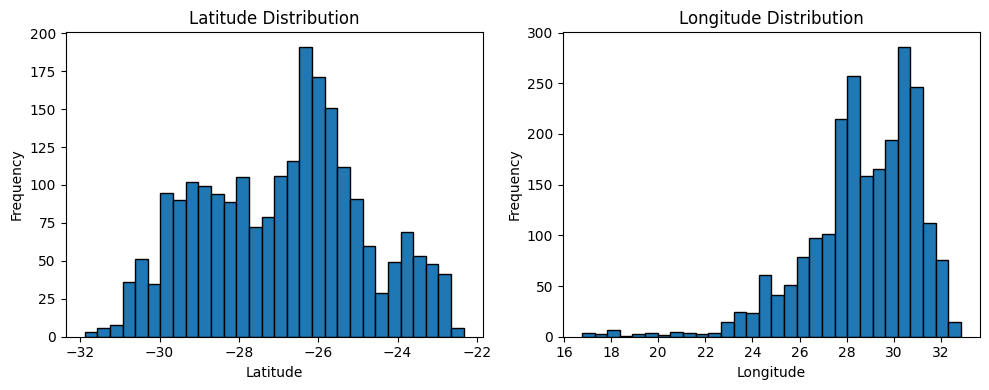

In [ ]:
geographical_features = ['latitude', 'longitude']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(X_train['latitude'], bins=30, edgecolor='black')
axes[0].set_title('Latitude Distribution')
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Frequency')

axes[1].hist(X_train['longitude'], bins=30, edgecolor='black')
axes[1].set_title('Longitude Distribution')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Visualizing the data on a map
Visualising the data points over the map of South Africa may reveal some patterns. We can plot a point for each ward, as localised by the latitude and longitude features. Colouring the points based on their target value lets us investigate if there is a spatial relationship between data points and targets:
- Points are green if their target value is lower than the 25th percentile of the targets
- Blue if their target is between the 25th and the 50th percentile
- Orange if their target is between the 50th and the 75th percentile
- Red if their target is greater than the 75th percentile

In [ ]:
!pip install geojson

In [ ]:
import folium
import geojson

# Get centre of map
average_lat = X_train.latitude.mean()
average_lon = X_train.longitude.mean()

# Add map
mymap = folium.Map(location=[average_lat, average_lon], zoom_start=6)

# Target quantiles
target_quantiles = [np.quantile(y_train, 0.25),
                    np.quantile(y_train, 0.50),
                    np.quantile(y_train, 0.75)]

# Add markers for each location
locations = list(zip(X_train.latitude, X_train.longitude, y_train))
for lat, lon, target in locations:
    color = ""
    if target < target_quantiles[0]:
        color="green"
    elif target < target_quantiles[1]:
        color="blue"
    elif target < target_quantiles[2]:
        color="orange"
    else:
        color="red"

    folium.CircleMarker(location=[lat, lon], radius=0.5, color=color, opacity=.6).add_to(mymap)

# Get South Africa geometry
with open('/content/drive/MyDrive/Applied_AI_Week02/Week04/Female_headed_household_data/countries.geojson') as f:
    gj = geojson.load(f)

south_africa_geometry = next(x for x in gj['features']
                             if x['properties']['ISO_A3'] == 'ZAF')

# Add South Africa delimitation
folium.GeoJson(south_africa_geometry, style_function=lambda x: {
        "fillColor": "#ffff00",
        "color": "black",
        "weight": 1.5}).add_to(mymap)

mymap

We can observe that larger target values (red and orange dots) tend to be clustered around the eastern side of the South African shore and the far northeastern side of the country. On the other hand, the smallest target values (blue and green dots) tend to be clustered around the city of Johannesburg, with some points also present along the shore. Thus, this map indicates that the latitude and longitude can be relevant features in the dataset which, when combined, can have a correlation to the target and have the potential to help models in their predictions.

#### Percentages
The vast majority of dataset features represent percentages. There are several groups of options (e.g. dwelling type), with one column representing the prevalence of each option in each ward.

For convenience, we group them using the start of their column names.

In [ ]:
PERCENTAGE_FEATURE_PREFIXES = [
    "dwelling_",
    "school_",
    "satellite_tv_",
    "car_",
    "landline_",
    "language_",
    "ethnicity_",
    "electricity_",
    "piped_water_"
]

percentage_features = []
for prefix in PERCENTAGE_FEATURE_PREFIXES:
    for column in X_train.columns:
        if column.startswith(prefix):
            percentage_features.append(column)

percentage_features

['dwelling_brick_concrete',
 'dwelling_traditional',
 'dwelling_flat',
 'dwelling_cluster_complex',
 'dwelling_semidetached_complex',
 'dwelling_semidetached',
 'dwelling_house_backyard',
 'dwelling_shack_backyard',
 'dwelling_shack_not_backyard',
 'dwelling_room',
 'dwelling_tent_caravan',
 'dwelling_other',
 'dwelling_unspecified',
 'dwelling_na',
 'school_yes',
 'school_no',
 'school_unknown',
 'school_unspecified',
 'school_na',
 'satellite_tv_yes',
 'satellite_tv_no',
 'car_yes',
 'car_no',
 'landline_yes',
 'landline_no',
 'language_afrikaans',
 'language_english',
 'language_isindebele',
 'language_isixhosa',
 'language_isizulu',
 'language_sepedi',
 'language_sesotho',
 'language_setswana',
 'language_sign',
 'language_siswati',
 'language_tshivenda',
 'language_xitsonga',
 'language_other',
 'language_unspecified',
 'language_na',
 'ethnicity_black_african',
 'ethnicity_coloured',
 'ethnicity_asian',
 'ethnicity_white',
 'ethnicity_other',
 'electricity_yes',
 'piped_water_in_

We should have a little sanity check for this data. Do all values of the percentage features lie between 0 and 1, as all good percentages should?

In [ ]:
for feature in percentage_features:
    if not ((X_train[feature] >= 0).all() and (X_train[feature] <= 1).all()):
        print(f"No, Feature {feature} contains values outside the [0, 1] range")
    else:
        print(f"Yes, Feature {feature} values are all within [0, 1]")

Yes, Feature dwelling_brick_concrete values are all within [0, 1]
Yes, Feature dwelling_traditional values are all within [0, 1]
Yes, Feature dwelling_flat values are all within [0, 1]
Yes, Feature dwelling_cluster_complex values are all within [0, 1]
Yes, Feature dwelling_semidetached_complex values are all within [0, 1]
Yes, Feature dwelling_semidetached values are all within [0, 1]
Yes, Feature dwelling_house_backyard values are all within [0, 1]
Yes, Feature dwelling_shack_backyard values are all within [0, 1]
Yes, Feature dwelling_shack_not_backyard values are all within [0, 1]
Yes, Feature dwelling_room values are all within [0, 1]
Yes, Feature dwelling_tent_caravan values are all within [0, 1]
Yes, Feature dwelling_other values are all within [0, 1]
Yes, Feature dwelling_unspecified values are all within [0, 1]
Yes, Feature dwelling_na values are all within [0, 1]
Yes, Feature school_yes values are all within [0, 1]
Yes, Feature school_no values are all within [0, 1]
Yes, Featur

Looks like they do, so we already know the range of possible values for these features. There are also many of them, so plotting a histogram for each would not be very readable.

A better alternative is to plot a bar chart for each group of options (e.g. dwelling types). Each chart shows the possible options along with its mean percentage across wards.

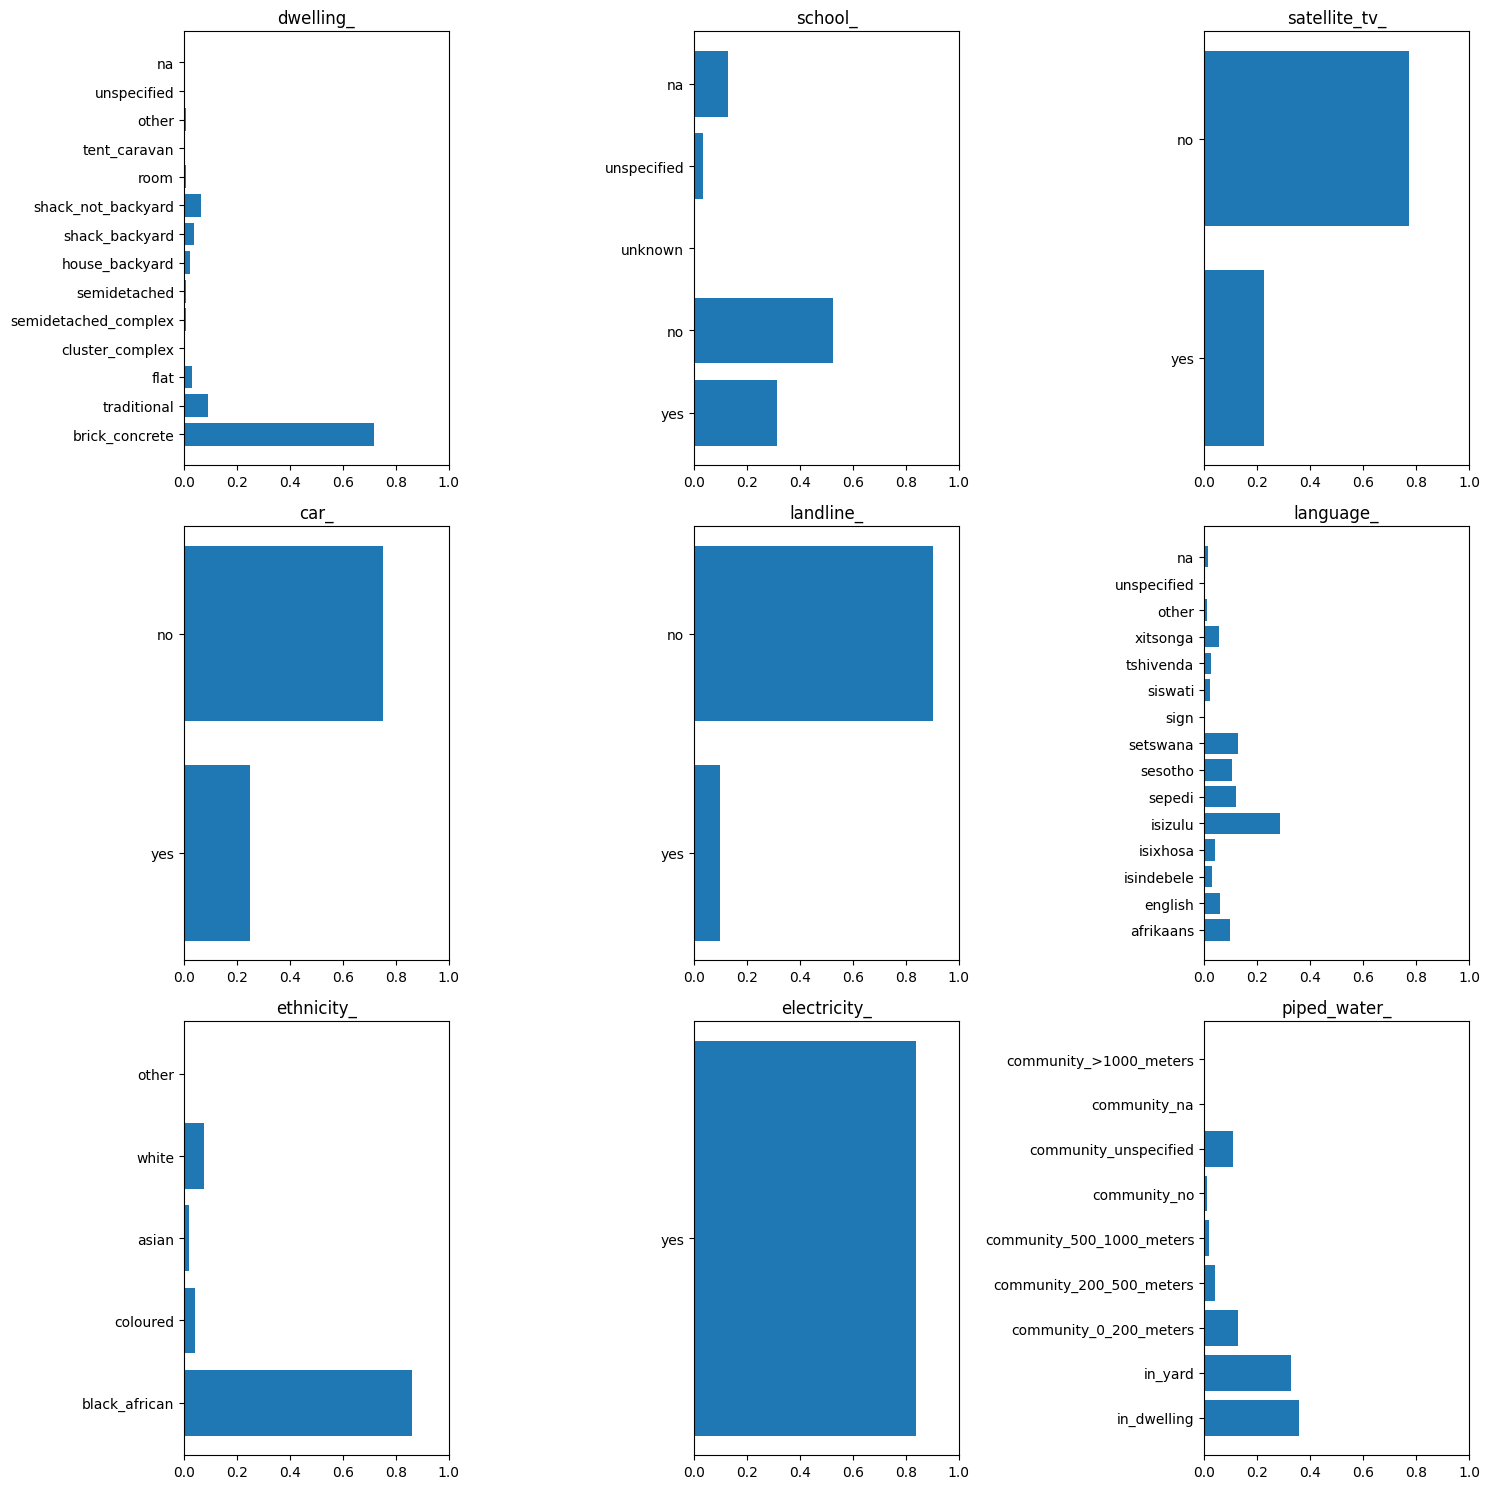

In [ ]:
from matplotlib.axes import Axes

def plot_mean_percentages(data: pd.DataFrame, feature_prefix: str, axes: Axes) -> None:
    """
    Plots the mean prevalence of each option in a group of options.
    The data is plotted as a bar graph in the given axes
    """
    means = {}
    for column in [c for c in data.columns if c.startswith(feature_prefix)]:
        simplified_name = column.replace(feature_prefix, "")
        means[simplified_name] = data[column].mean()

    axes.set_title(feature_prefix)
    axes.set_xlim(0, 1)
    axes.barh(list(means.keys()), list(means.values()))


fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()
for i, prefix in enumerate(PERCENTAGE_FEATURE_PREFIXES):
    plot_mean_percentages(X_train, prefix, axes[i])

fig.tight_layout()
plt.show()

While interesting, this plot reveals a couple of issues.

Firstly, some options seem to be very underrepresented - some may even be always 0. For this exercise, we just want to find the percentages which are always 0 (or any other constant) so we can safely remove them from the dataset.

In [ ]:
constant_features = []

for feature in percentage_features:
    if (X_train[feature] == 0).all():
        constant_features.append(feature)

constant_features

['dwelling_unspecified',
 'dwelling_na',
 'language_unspecified',
 'piped_water_community_na',
 'piped_water_community_>1000_meters']

Secondly, some features seem redundant: they are both percentages where one feature shows the proportion of "yes" and one shows the proportion of "no". Assuming that the two sum up to one, it's safe to remove one of the options without losing information.

Let's run a quick sanity check to see if the percentages of all options in a group sum up to 1.

In [ ]:
def check_percentages(df: pd.DataFrame, prefix: str):
    tot = np.zeros(len(df), dtype=np.float32)
    for column in [c for c in df.columns if c.startswith(prefix)]:
        tot += df[column].to_numpy().ravel()
    return np.all(np.isclose(tot, 1))

for prefix in PERCENTAGE_FEATURE_PREFIXES:
    is_total_1 = check_percentages(X_train, prefix)
    if not is_total_1:
        print(f"Percentages starting with \"{prefix}\" do not sum up to 1")

Percentages starting with "electricity_" do not sum up to 1


The only feature which doesn't is electricity use, which is already sparsely encoded (i.e. it only has 1 option). There are 3 other groups which can be encoded in this way, as they only have one option for "yes" and one for "no". Add one of their 2 columns to the list below.

In [ ]:
redundant_features = ['satellite_tv_no', 'car_no', 'landline_no']

#### Unconstrained features
The last 3 features in the dataset can simply be plotted as histograms.

In [ ]:
other_features = ['total_households', 'total_individuals', 'nightlights']

## Preprocessing

Now that we've visualised the distributions and uncovered some issues with the data, write a preprocessing `Pipeline` to prepare the data before training.

Based on the previous exercises, there are 10 features which can be safely dropped; you can do this in a `ColumnTransformer` using the special "drop" keyword.

Based on the prevalence of numerical features, you may be tempted to apply a scaler to everything else. Is this a sensible choice?

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

useless_features = [
    *id_features,
    *redundant_features,
    *constant_features
]

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_cols', 'drop', useless_features),
        ('scale_numerical', StandardScaler(), other_features)
        # You can add other transformations here for remaining columns
    ],
    remainder='passthrough' # 'passthrough' keeps other columns, 'drop' removes them
)

## Task 1: Linear models
In this task, we will train and evaluate some [linear models](https://scikit-learn.org/stable/modules/linear_model.html#). We will investigate the effect of different types and strength of regularisation on our models.

These are the models we're going to use:
- [Ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)
- [LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso)
- [ElasticNet](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)

The main difference between them is the type of regularisation. See the lecture notes and the documentation linked above for more information.

### 1.1 Train and evaluate models
Create a pipeline to train and test the linear models with varying regularization settings, and chose the best model for predicting the target. Print the average cross-validation performance (with the standard deviation) as well as the test performance.

For Ridge regression and LASSO, only change the strength of the regularisation. Check the scikit docs: which hyperparameter controls this?

> To cover a lot of possible values quickly, the hyperparameter ranges should be picked on a log scale

For ElasticNet, also change the relative weight of the L2 and L1 norms. In this case, try only 2-4 values: the plotting task later will be hard to read otherwise.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

def make_full_pipeline(model: BaseEstimator) -> Pipeline:
    return Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

def optimise_hyperparameters(model: Pipeline, hyperparams: dict, X_train: pd.DataFrame, y_train: npt.NDArray[np.float32]):
    tuner = GridSearchCV(model,
                         cv=5,
                         param_grid=hyperparams,
                         n_jobs=-1,
                         refit=True,
                         scoring="neg_root_mean_squared_error")
    return tuner.fit(X_train, y_train)

# Define the parameter grids for each model
alpha_range = [0.01, 0.1, 0.5, 1, 5, 10]

ridge_params = {
    'regressor__alpha': alpha_range
}
lasso_params = {
    'regressor__alpha': alpha_range
}
elastic_params = {
    'regressor__alpha': alpha_range,
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}

# Optimise the hyperparameters
tuned_ridge = optimise_hyperparameters(make_full_pipeline(Ridge(random_state=RANDOM_STATE)), ridge_params, X_train, y_train)
tuned_lasso = optimise_hyperparameters(make_full_pipeline(Lasso(random_state=RANDOM_STATE)), lasso_params, X_train, y_train)
tuned_elastic = optimise_hyperparameters(make_full_pipeline(ElasticNet(random_state=RANDOM_STATE)), elastic_params, X_train, y_train)

Then, let's evaluate the trained models.

In [ ]:
from sklearn.metrics import root_mean_squared_error

def evaluate_performance(model_name: str, tuner: GridSearchCV, results_df: pd.DataFrame):
    cv_test_scores = tuner.cv_results_["mean_test_score"]
    cv_score_mean = cv_test_scores.mean()
    cv_score_std = cv_test_scores.std()

    y_pred = tuner.predict(X_test)
    test_score = root_mean_squared_error(y_pred, y_test)

    results_df.loc[len(results_df)] = [model_name, tuner.best_params_, -cv_score_mean, cv_score_std, test_score]

results_df = pd.DataFrame(columns=['Model', 'Best Hyperparameters', 'Mean CV Score (RMSE)', "CV score std", 'Test RMSE'])
evaluate_performance("Ridge", tuned_ridge, results_df)
evaluate_performance("LASSO", tuned_lasso, results_df)
evaluate_performance("ElasticNet", tuned_elastic, results_df)

results_df

,Model,Best Hyperparameters,Mean CV Score (RMSE),CV score std,Test RMSE
0,Ridge,{'regressor__alpha': 0.1},4.016037,0.181954,3.810930
1,LASSO,{'regressor__alpha': 0.01},7.024356,2.344740,3.961234
2,ElasticNet,"{'regressor__alpha': 0.01, 'regressor__l1_rati...",7.259278,1.986247,4.214688


### 1.2 Plot CV performance as function of hyperparameters
Create a plot to show the effect of the regularisation strength on each model's performance. For each model, plot how the CV performance varies as alpha increases.

Note that you'll have to plot ElasticNet performance separately for each value of L1 ratio.

> Hint: if you're using a log scale, `plt.semilogx` is a good function to use here

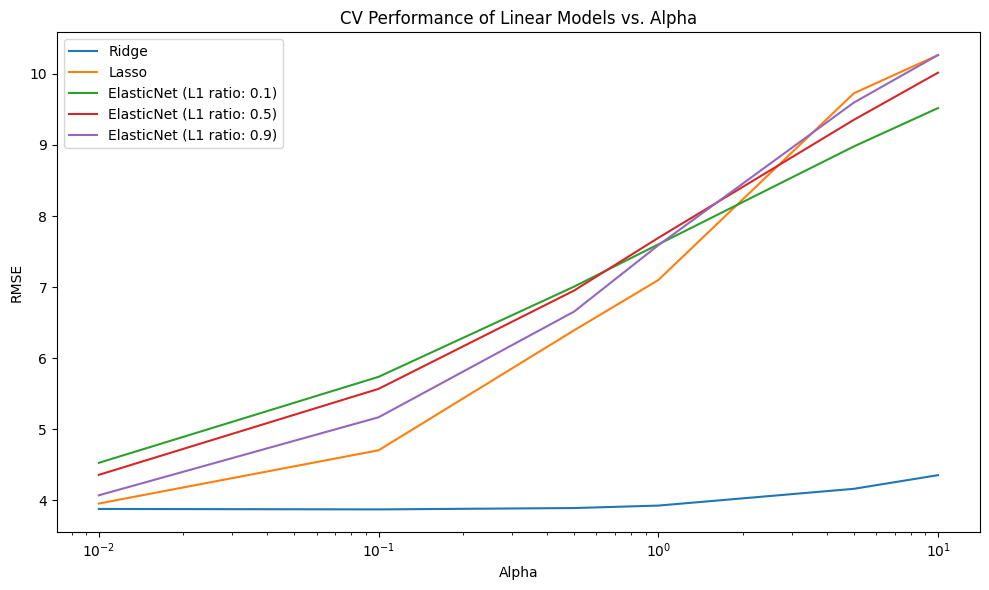

In [ ]:
def plot_model_performance(grid_search: GridSearchCV, model_name: str, axes: Axes) -> None:
    """
    Plot the error observed in the given grid search
    for each value of the regularisation strength hyperparameter.
    """
    axes.set_ylabel("RMSE")
    axes.set_xlabel("Alpha")
    axes.set_xscale('log') # Use log scale for alpha

    if model_name != 'ElasticNet':
        results = grid_search.cv_results_['mean_test_score']
        alphas = grid_search.cv_results_['param_regressor__alpha'].data
        axes.plot(alphas, -results, label=model_name)
    else:
        # Handle ElasticNet separately for each l1_ratio
        for l1_ratio in grid_search.param_grid['regressor__l1_ratio']:
            l1_results = []
            l1_alphas = []
            for i in range(len(grid_search.cv_results_['params'])):
                params = grid_search.cv_results_['params'][i]
                if params.get('regressor__l1_ratio') == l1_ratio:
                    l1_alphas.append(params['regressor__alpha'])
                    l1_results.append(grid_search.cv_results_['mean_test_score'][i])
            axes.plot(l1_alphas, -np.array(l1_results), label=f'{model_name} (L1 ratio: {l1_ratio})')
    axes.legend()
    axes.set_title(f'{model_name} CV Performance vs. Alpha')

# Create a single figure and axis
fig, axes = plt.subplots(figsize=(10, 6))

# Plot the performance of each model on the same axis
plot_model_performance(tuned_ridge, 'Ridge', axes)
plot_model_performance(tuned_lasso, 'Lasso', axes)
plot_model_performance(tuned_elastic, 'ElasticNet', axes)

# Customize overall plot
axes.set_title('CV Performance of Linear Models vs. Alpha')
axes.legend()
plt.tight_layout()
plt.show()

The difference is just that of regularisation effect. Ridge/l2 does not zero out all features, small weights remain, unlike lass/l1 which zeroes out features. Ridge/l2 selects corelated features, which is beneficial for this particualr dataset as demonstarted by the lower RMSE value. All ridge, lasso, and elastic net are all linear regression models.

Try generating this plot using different hyperparameter ranges for the cross-validation. What does it look like if you try a very broad range? What if you focus on very small values?

New alpha range: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
Re-optimizing Ridge with new alpha range...
Re-optimizing Lasso with new alpha range...
Re-optimizing ElasticNet with new alpha range...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+02, tolerance: 2.380e+01
  model = cd_fast.enet_coordinate_descent(


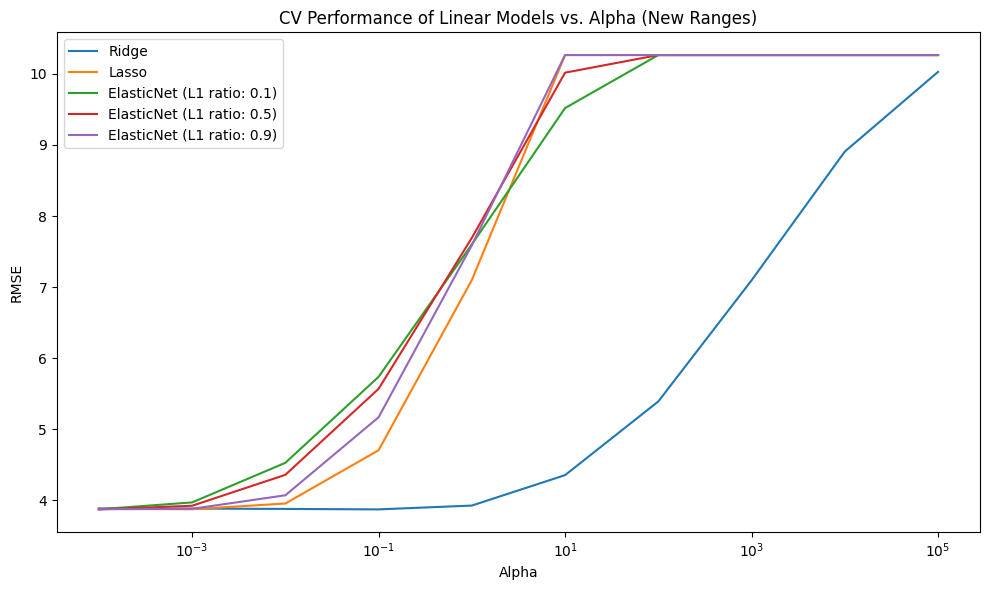

In [ ]:
import numpy as np

# Define new, broader alpha ranges for cross-validation
# Using np.logspace to get values on a log scale
new_alpha_range = np.logspace(-4, 5, 10).tolist() # From 0.0001 to 100000, 10 points

print(f"New alpha range: {new_alpha_range}")

# Update parameter grids with the new alpha range
new_ridge_params = {
    'regressor__alpha': new_alpha_range
}
new_lasso_params = {
    'regressor__alpha': new_alpha_range
}
new_elastic_params = {
    'regressor__alpha': new_alpha_range,
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}

# Re-optimise the hyperparameters with the new ranges
print("Re-optimizing Ridge with new alpha range...")
new_tuned_ridge = optimise_hyperparameters(make_full_pipeline(Ridge(random_state=RANDOM_STATE)), new_ridge_params, X_train, y_train)
print("Re-optimizing Lasso with new alpha range...")
new_tuned_lasso = optimise_hyperparameters(make_full_pipeline(Lasso(random_state=RANDOM_STATE)), new_lasso_params, X_train, y_train)
print("Re-optimizing ElasticNet with new alpha range...")
new_tuned_elastic = optimise_hyperparameters(make_full_pipeline(ElasticNet(random_state=RANDOM_STATE)), new_elastic_params, X_train, y_train)

# Create a new figure and axes for the updated plot
fig_new, axes_new = plt.subplots(figsize=(10, 6))

# Plot the performance of each model with the new ranges
plot_model_performance(new_tuned_ridge, 'Ridge', axes_new)
plot_model_performance(new_tuned_lasso, 'Lasso', axes_new)
plot_model_performance(new_tuned_elastic, 'ElasticNet', axes_new)

# Customize overall plot
axes_new.set_title('CV Performance of Linear Models vs. Alpha (New Ranges)')
axes_new.legend()
plt.tight_layout()
plt.show()

Do you see a significant difference between the 3 models?

We see underfitting when alpha becomes too large for all models. Ridge is still focusing on the corelated features it selects(earlier good performance), but then as alpha becomes large,  ridge stil keeps all features but makes their contributions negligible due to the excessive regularization. The result is a high bias and consequently a high RMSE, indicating poor performance.


### 1.3 Plot model coefficients
Create figures to show the models coefficients for model interpretation (i.e. including the feature names). For each model, you should show the 10 features with the largest coefficients.

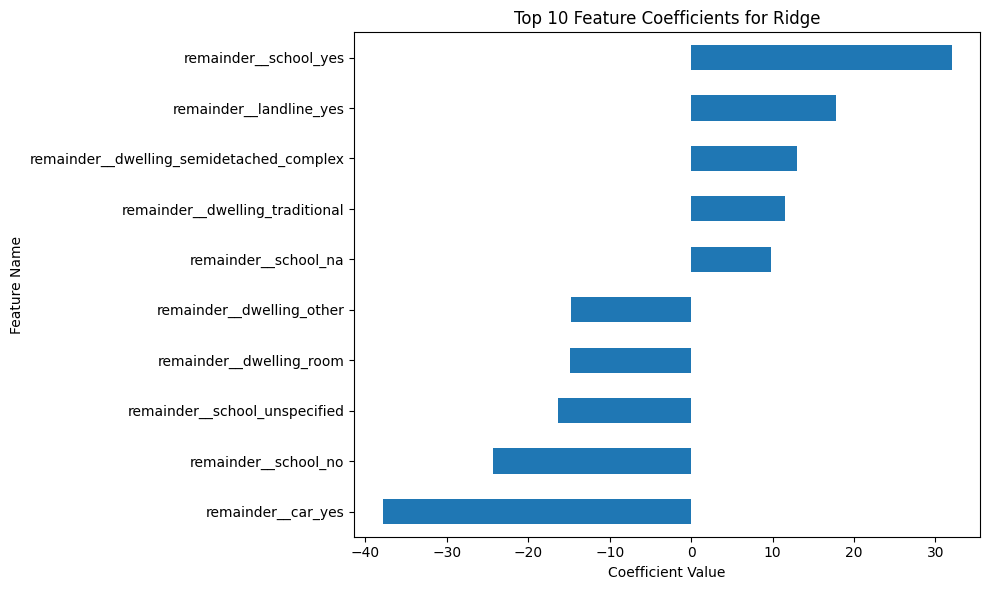

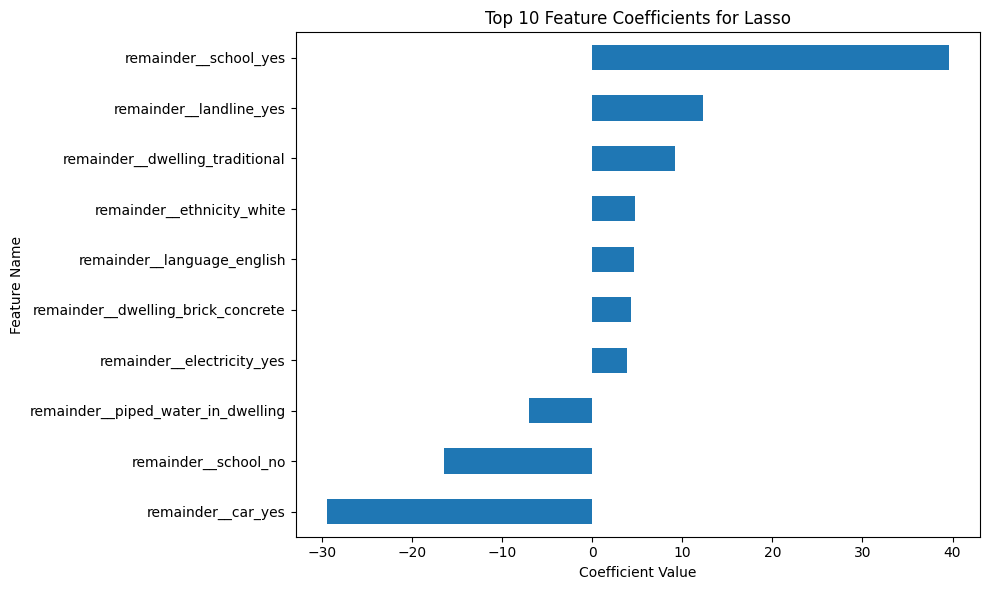

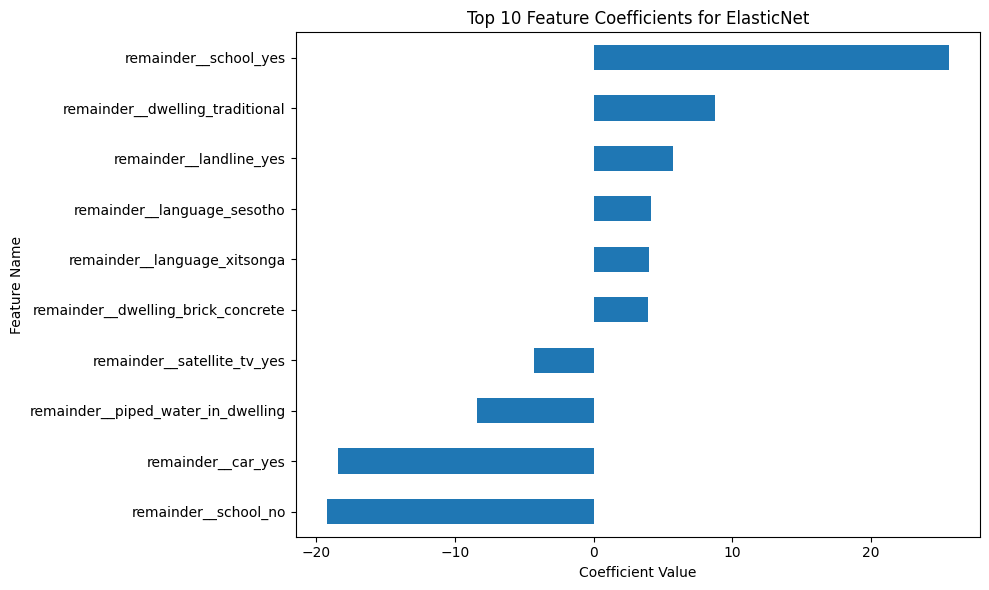

In [ ]:
def plot_top_model_coefficients(tuner: GridSearchCV, model_name: str) -> None:
    # Get the best estimator from the GridSearchCV result
    best_estimator = tuner.best_estimator_['regressor']

    # Get the feature names after preprocessing
    # This requires fitting the preprocessor once to get feature names
    preprocessor_fit = tuner.best_estimator_['preprocessor'].fit(X_train)
    transformed_feature_names = preprocessor_fit.get_feature_names_out()

    # Extract coefficients
    if hasattr(best_estimator, 'coef_'):
        coefficients = best_estimator.coef_
    else:
        # Some estimators might not have coef_ (e.g., if it's a dummy estimator)
        print(f"Warning: {model_name} does not have 'coef_' attribute.")
        return

    # Create a Series for easy sorting
    coef_series = pd.Series(coefficients, index=transformed_feature_names)

    # Get top 10 coefficients by absolute magnitude
    top_10_coefs = coef_series.abs().sort_values(ascending=False).head(10).index

    # Filter the actual coefficients for these top 10 features
    top_10_values = coef_series[top_10_coefs].sort_values(ascending=True) # Sort for better plot order

    # Plotting
    plt.figure(figsize=(10, 6))
    top_10_values.plot(kind='barh')
    plt.title(f'Top 10 Feature Coefficients for {model_name}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

plot_top_model_coefficients(tuned_ridge, "Ridge")
plot_top_model_coefficients(tuned_lasso, "Lasso")
plot_top_model_coefficients(tuned_elastic, "ElasticNet")

Do the different models agree with each other? What about looking at the smallest 10 weights?

### 1.4 Check weight distribution
Now plot a histogram showing the distribution of weight magnitudes for the 3 models. What do you observe?

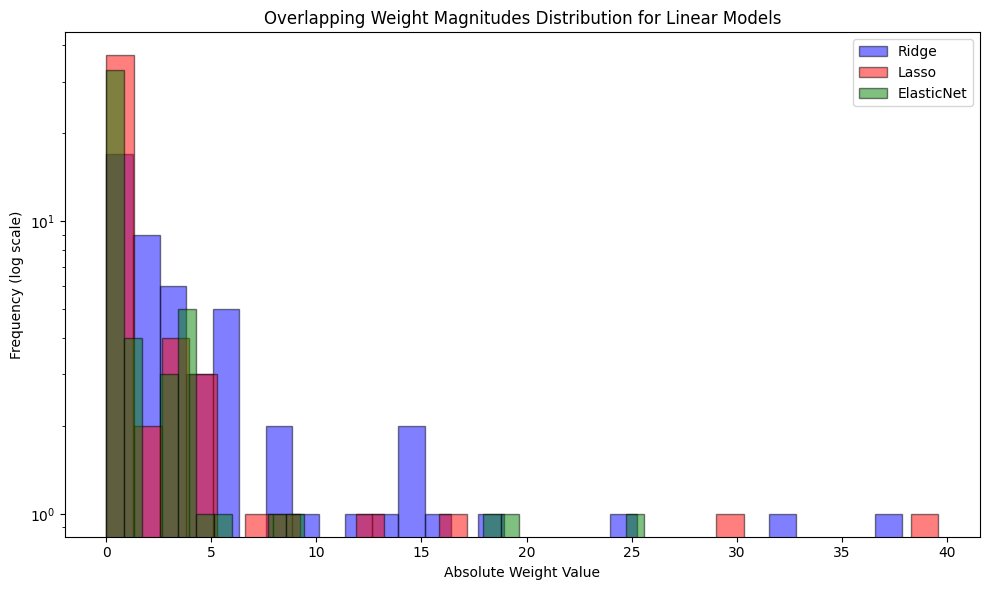

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

def plot_overlapping_weight_distribution(tuner: GridSearchCV, model_name: str, ax: plt.Axes, color: str) -> None:
    best_estimator = tuner.best_estimator_['regressor']
    if hasattr(best_estimator, 'coef_'):
        coefficients = best_estimator.coef_
        ax.hist(np.abs(coefficients), bins=30, edgecolor='black', alpha=0.5, label=model_name, color=color, log=True)
    else:
        print(f"Warning: {model_name} does not have 'coef_' attribute to plot weight distribution.")

plot_overlapping_weight_distribution(tuned_ridge, "Ridge", ax, 'blue')
plot_overlapping_weight_distribution(tuned_lasso, "Lasso", ax, 'red')
plot_overlapping_weight_distribution(tuned_elastic, "ElasticNet", ax, 'green')

ax.set_title('Overlapping Weight Magnitudes Distribution for Linear Models')
ax.set_xlabel('Absolute Weight Value')
ax.set_ylabel('Frequency (log scale)')
ax.legend()
plt.tight_layout()
plt.show()

### 1.5 Check model similarity
Finally, create a similarity matrix to show the similarity of the coefficients across the different models. Which ones are more similar?

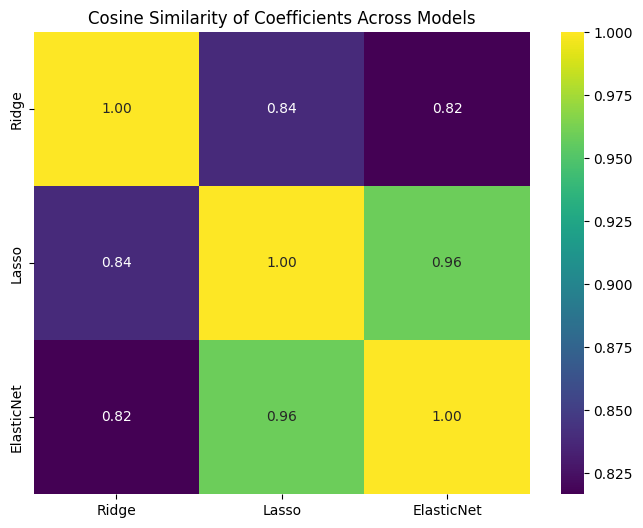

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Get coefficients from each best estimator
coefs = {}
models = {
    "Ridge": tuned_ridge,
    "Lasso": tuned_lasso,
    "ElasticNet": tuned_elastic
}

# Get feature names from one of the preprocessors
# Ensure consistency by fitting one preprocessor and getting names
preprocessor_fit = tuned_ridge.best_estimator_['preprocessor'].fit(X_train)
feature_names = preprocessor_fit.get_feature_names_out()

for name, tuner in models.items():
    best_estimator = tuner.best_estimator_['regressor']
    if hasattr(best_estimator, 'coef_'):
        coefs[name] = pd.Series(best_estimator.coef_, index=feature_names)
    else:
        print(f"Warning: {name} does not have 'coef_' attribute.")

# Create a DataFrame of coefficients for easy comparison
coef_df = pd.DataFrame(coefs)

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(coef_df.T)

# Create a DataFrame for the similarity matrix with model names as index/columns
similarity_df = pd.DataFrame(similarity_matrix, index=coef_df.columns, columns=coef_df.columns)

# Plot the similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Cosine Similarity of Coefficients Across Models')
plt.show()

### Discussion: How does the performance compare across models? Are the coefficients similar across models?

## Task 2: Tree and ensemble models

### 2.1 Train models
For the same dataset compare the performance of a decision tree and ensemble methods (e.g. bagging, boosting and gradient boosting).

Trees: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree  
Ensembles: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Initialize models
decision_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
bagging = BaggingRegressor(random_state=RANDOM_STATE)
boosting = AdaBoostRegressor(random_state=RANDOM_STATE)
gradient_boosting = GradientBoostingRegressor(random_state=RANDOM_STATE)

models = {
    "Decision Tree": decision_tree,
    "Bagging": bagging,
    "Boosting": boosting,
    "Gradient Boosting": gradient_boosting
}

# Define parameter grids
decision_tree_params = {'regressor__max_depth': [3, 20]}
bagging_params = {'regressor__n_estimators': [5,  50, 100]}
boosting_params = {'regressor__n_estimators': [5, 50, 100]}
gradient_boosting_params = {'regressor__n_estimators': [5, 50, 100]}

# Create a dictionary to hold the parameter grids
param_grids = {
    "Decision Tree": decision_tree_params,
    "Bagging": bagging_params,
    "Boosting": boosting_params,
    "Gradient Boosting": gradient_boosting_params
}

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Best Hyperparameters', 'Mean CV Score (RMSE)', "CV score std", 'Test RMSE'])

# Use the functions we already defined
# to train and evaluate the models
fitted_models = {}
for name, model in models.items():
    print(f"Fitting {name}...")
    tuned_model = optimise_hyperparameters(make_full_pipeline(model), param_grids[name], X_train, y_train)
    fitted_models[name] = tuned_model
    evaluate_performance(name, tuned_model, results_df)

# Display the results
display(results_df)

Fitting Decision Tree...
Fitting Bagging...
Fitting Boosting...
Fitting Gradient Boosting...


,Model,Best Hyperparameters,Mean CV Score (RMSE),CV score std,Test RMSE
0,Decision Tree,{'regressor__max_depth': 3},5.124996,0.080784,4.984641
1,Bagging,{'regressor__n_estimators': 100},3.720793,0.164314,3.377445
2,Boosting,{'regressor__n_estimators': 100},4.239063,0.205827,4.143048
3,Gradient Boosting,{'regressor__n_estimators': 100},4.849037,1.665995,3.590588


### 2.2 Plot feature importances
Create figures to show the top 10 features accordingly to feature importance for the different models

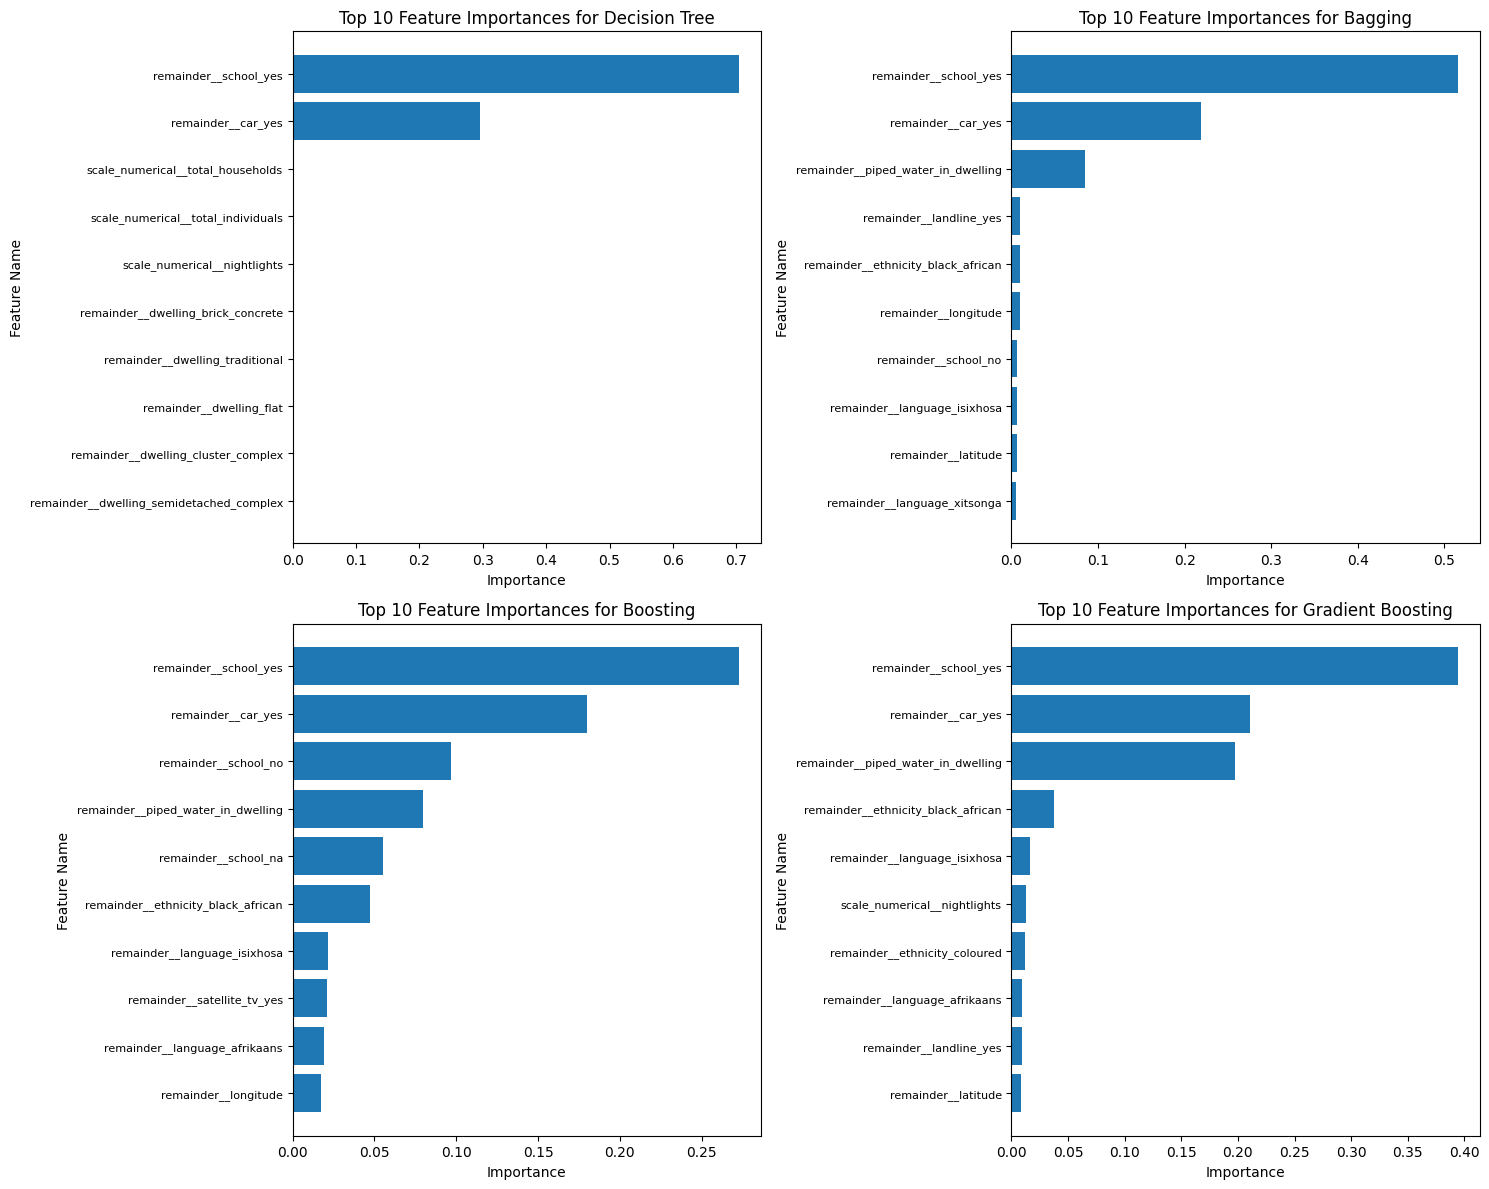

In [ ]:
def plot_feature_importances(model: GridSearchCV, name: str, ax: Axes):
    best_estimator = model.best_estimator_['regressor']

    # Get feature names after preprocessing
    preprocessor_fit = model.best_estimator_['preprocessor'].fit(X_train)
    feature_names = preprocessor_fit.get_feature_names_out()

    importances = None
    if hasattr(best_estimator, 'feature_importances_'):
        importances = best_estimator.feature_importances_
    elif hasattr(best_estimator, 'coef_'): # For linear models, though this task is for tree-based
        importances = np.abs(best_estimator.coef_)
    elif hasattr(best_estimator, 'estimators_') and hasattr(best_estimator.estimators_[0], 'feature_importances_'):
        # For ensemble models like Bagging or RandomForest if base estimator has feature_importances_
        # Take mean of importances from individual estimators
        importances = np.mean([est.feature_importances_ for est in best_estimator.estimators_], axis=0)
    else:
        print(f"Warning: {name} does not have feature importances or coefficients attribute.")
        return

    if importances is not None:
        feature_importances = pd.Series(importances, index=feature_names)
        # Get top 10 features
        top_10_features = feature_importances.nlargest(10)

        ax.set_title(f'Top 10 Feature Importances for {name}')
        ax.barh(top_10_features.index[::-1], top_10_features.values[::-1]) # Reverse for plotting largest at top
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature Name')
        ax.set_xlim(left=0) # Ensure x-axis starts at 0
        ax.tick_params(axis='y', labelsize=8)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plotting feature importances for each model
for i, (name, model) in enumerate(fitted_models.items()):
    plot_feature_importances(model, name, axes[i])

plt.tight_layout()
plt.show()

**Discussion**  
**Were the features selected similar across the different models?**

Boosting and Gradient boosting were more diverse in selecting features, and thus performed better, with lower RMSE's than the decision tree and bagging methods.

### 2.3 Pruning trees
Compare two different approaches for prunning a decision tree (cost-complexity prunning and max leaves nodes) and plot the resulting trees.

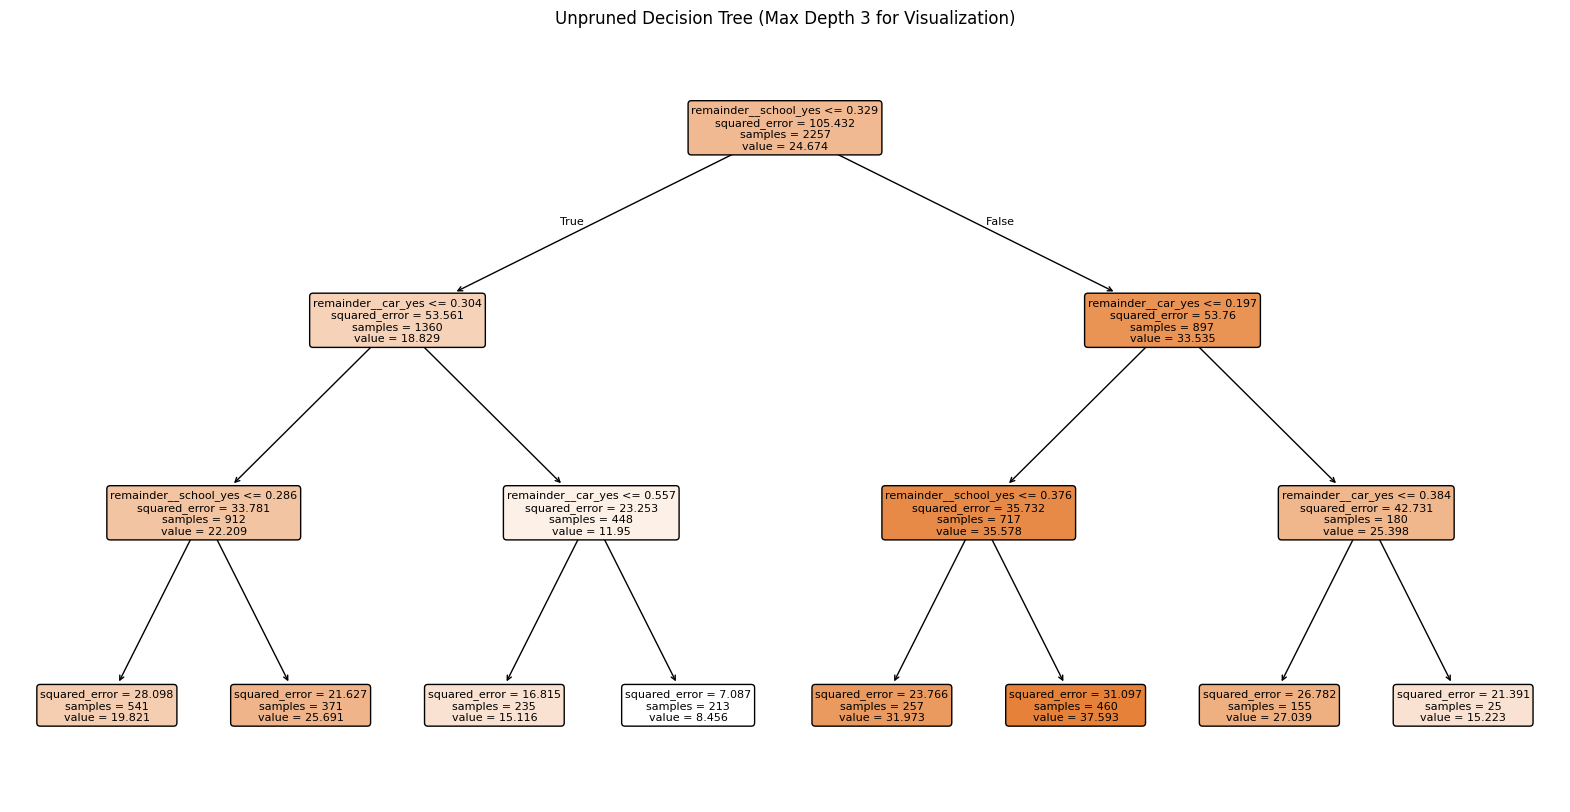

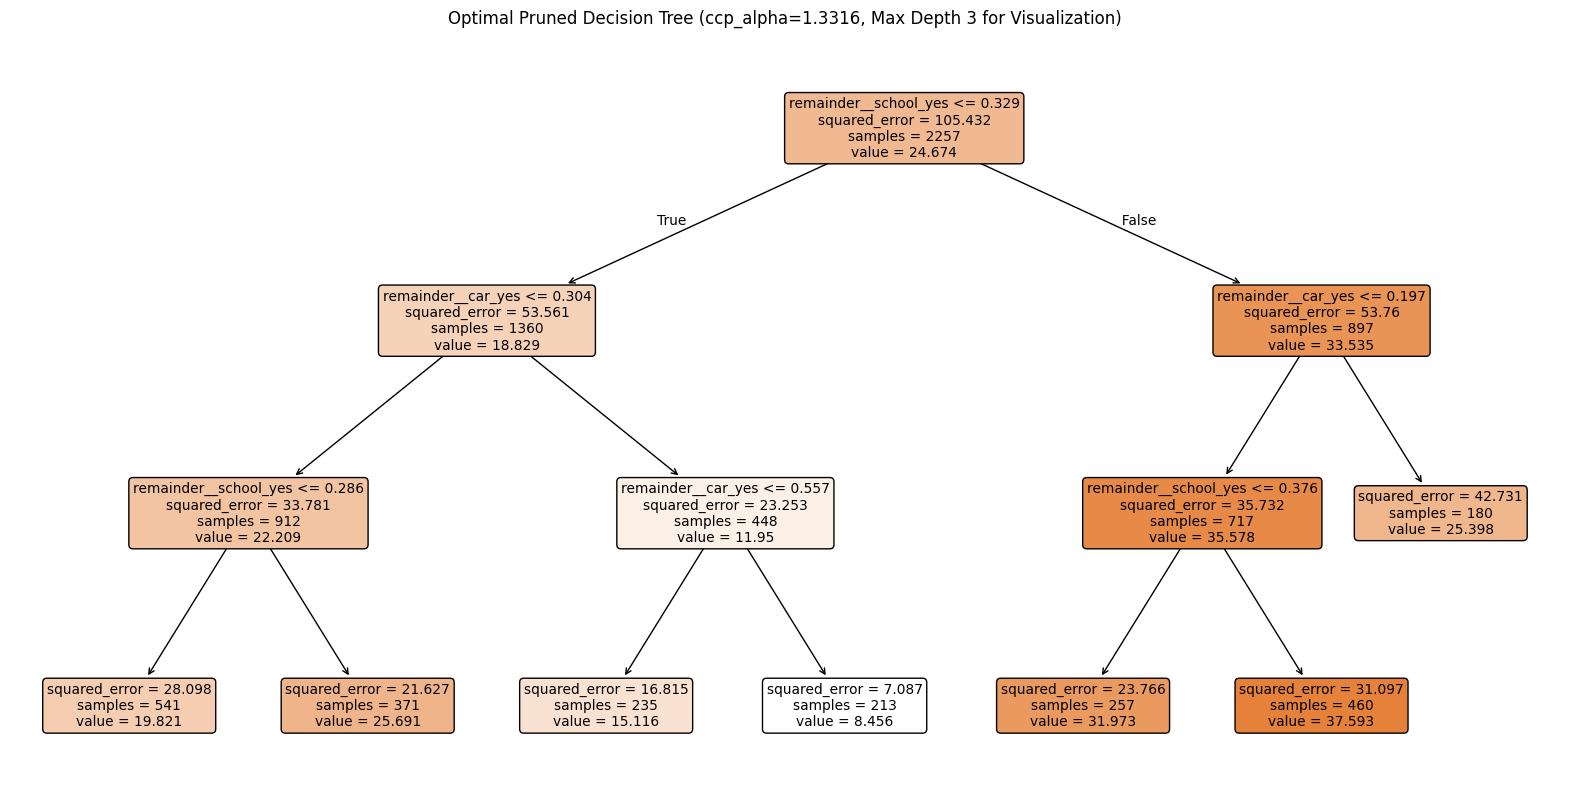

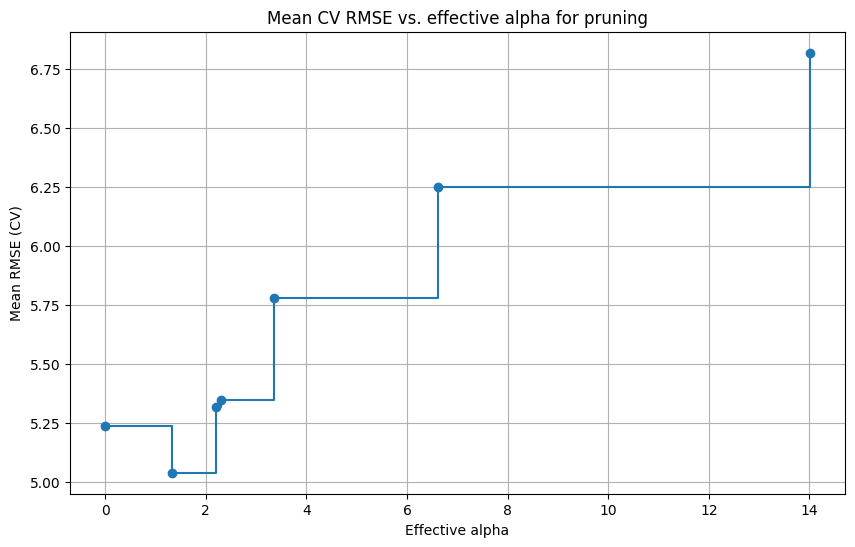

Optimal ccp_alpha: 1.3316
Minimum Mean CV RMSE: 5.0374


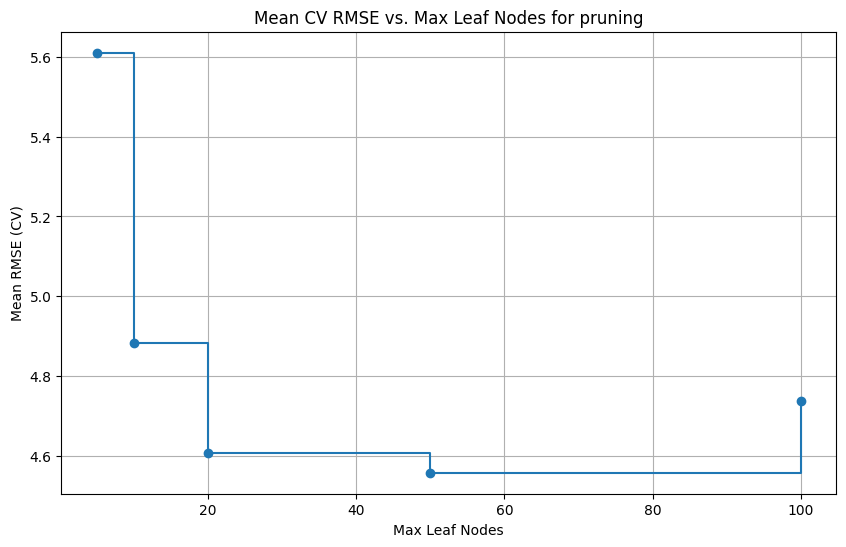

Optimal max_leaf_nodes: 50
Minimum Mean CV RMSE with max_leaf_nodes: 4.5569

Test RMSE of the optimal max_leaf_nodes pruned Decision Tree: 4.1193


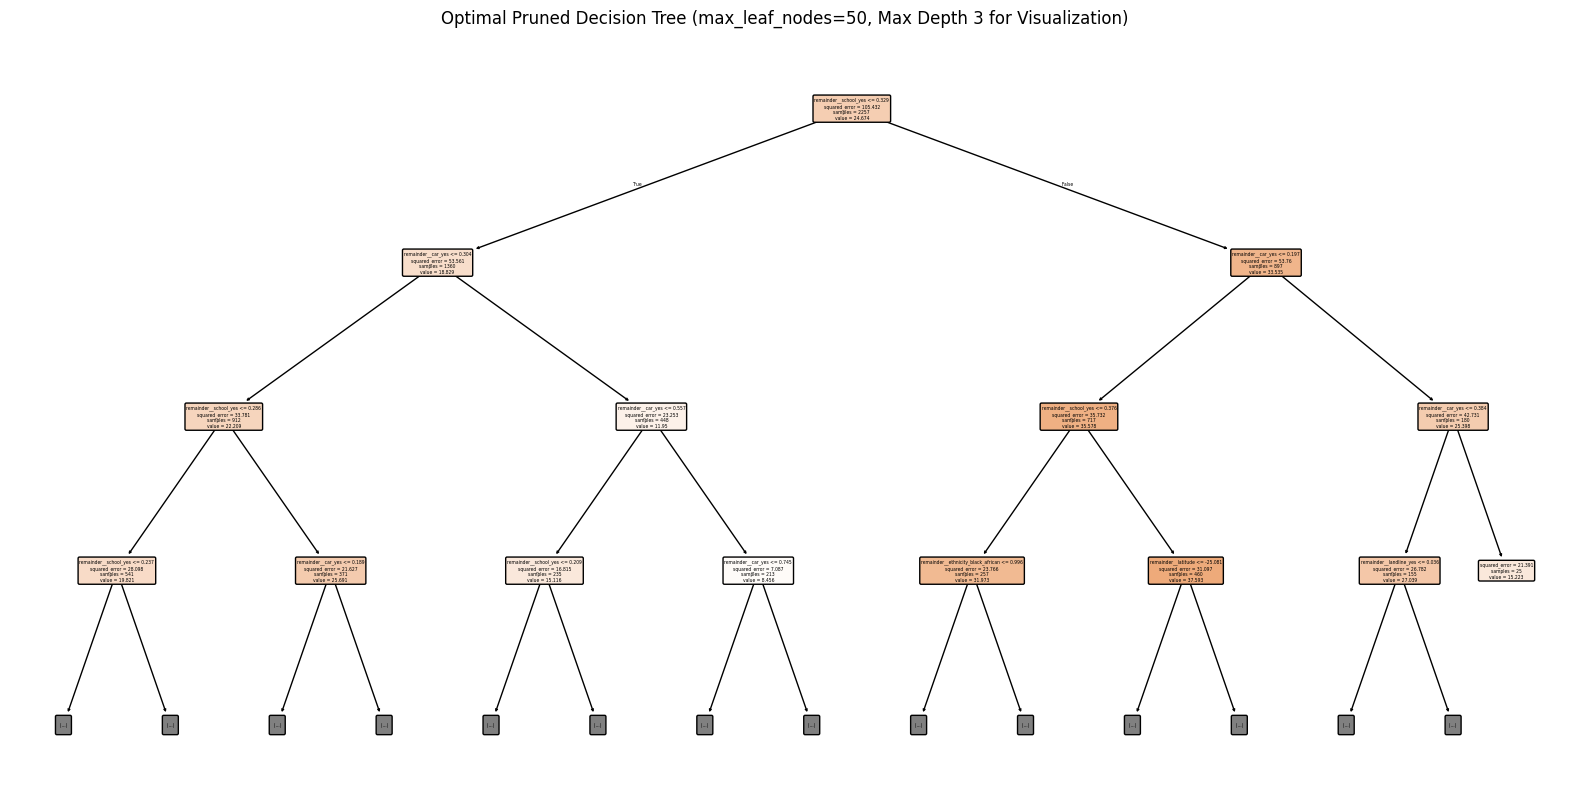

In [ ]:
from sklearn.tree import plot_tree

# Plot the unpruned tree (or a section of it for readability)
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor_unpruned, filled=True, max_depth=3, feature_names=feature_names, rounded=True)
plt.title("Unpruned Decision Tree (Max Depth 3 for Visualization)")
plt.show()

# Plot the optimally pruned tree
plt.figure(figsize=(20, 10))
plot_tree(final_pruned_dt_regressor, filled=True, max_depth=3, feature_names=feature_names, rounded=True)
plt.title(f"Optimal Pruned Decision Tree (ccp_alpha={optimal_ccp_alpha:.4f}, Max Depth 3 for Visualization)")
plt.show()

# Plot the RMSE vs ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], rmse_scores[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Mean RMSE (CV)")
plt.title("Mean CV RMSE vs. effective alpha for pruning")
plt.grid(True)
plt.show()

# Find the optimal ccp_alpha (alpha that minimizes RMSE)
optimal_ccp_alpha_idx = np.argmin(rmse_scores[:-1])
optimal_ccp_alpha = ccp_alphas[optimal_ccp_alpha_idx]
optimal_rmse = rmse_scores[optimal_ccp_alpha_idx]

print(f"Optimal ccp_alpha: {optimal_ccp_alpha:.4f}")
print(f"Minimum Mean CV RMSE: {optimal_rmse:.4f}")

# Now, let's try pruning with max_leaf_nodes
max_leaf_nodes_range = [5, 10, 20, 50, 100]
max_leaf_nodes_rmse_scores = []

for ml_nodes in max_leaf_nodes_range:
    dt_ml_pruned = DecisionTreeRegressor(random_state=RANDOM_STATE, max_leaf_nodes=ml_nodes)
    pruned_pipeline_ml = Pipeline([
        ('preprocessor', dt_pipeline['preprocessor']),
        ('regressor', dt_ml_pruned)
    ])
    scores_ml = cross_val_score(pruned_pipeline_ml, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    max_leaf_nodes_rmse_scores.append(-scores_ml.mean())

# Plot the RMSE vs max_leaf_nodes
plt.figure(figsize=(10, 6))
plt.plot(max_leaf_nodes_range, max_leaf_nodes_rmse_scores, marker='o', drawstyle="steps-post")
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Mean RMSE (CV)")
plt.title("Mean CV RMSE vs. Max Leaf Nodes for pruning")
plt.grid(True)
plt.show()

# Find the optimal max_leaf_nodes
optimal_ml_nodes_idx = np.argmin(max_leaf_nodes_rmse_scores)
optimal_max_leaf_nodes = max_leaf_nodes_range[optimal_ml_nodes_idx]
optimal_ml_rmse = max_leaf_nodes_rmse_scores[optimal_ml_nodes_idx]

print(f"Optimal max_leaf_nodes: {optimal_max_leaf_nodes}")
print(f"Minimum Mean CV RMSE with max_leaf_nodes: {optimal_ml_rmse:.4f}")

# Train the final pruned tree with the optimal max_leaf_nodes
final_ml_pruned_dt_regressor = DecisionTreeRegressor(random_state=RANDOM_STATE, max_leaf_nodes=optimal_max_leaf_nodes)
final_ml_pruned_pipeline = Pipeline([
    ('preprocessor', dt_pipeline['preprocessor']),
    ('regressor', final_ml_pruned_dt_regressor)
])
final_ml_pruned_pipeline.fit(X_train, y_train)

print(f"\nTest RMSE of the optimal max_leaf_nodes pruned Decision Tree: {root_mean_squared_error(final_ml_pruned_pipeline.predict(X_test), y_test):.4f}")

# Plot the optimally pruned tree using max_leaf_nodes
plt.figure(figsize=(20, 10))
plot_tree(final_ml_pruned_dt_regressor, filled=True, max_depth=3, feature_names=feature_names, rounded=True)
plt.title(f"Optimal Pruned Decision Tree (max_leaf_nodes={optimal_max_leaf_nodes}, Max Depth 3 for Visualization)")
plt.show()

Max leaf nodes performed relatively better, with a lower RMSE than the optimal pruning achieved. the cost-complexity pruning, despite being a principled method, might have been too aggressive. It could have removed branches that, while contributing little to impurity reduction in the training set, were actually important for capturing the underlying patterns and generalizing well to unseen data. Essentially, it might have over-pruned the tree, leading to an overly simple model and increased bias. Cost complexity is a post-pruning technique while max leaf nodes is pre-pruning technique.